# Problema 1

In [36]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Callable, List, Tuple, Optional, Dict


### Types y Helpers

In [37]:
# ----------------------------- Types & Helpers -----------------------------

Array = np.ndarray
Result = Tuple[Array, List[Array], List[float], List[float], int, bool]

def _as_array(x: Array | list | tuple) -> Array:
    return np.asarray(x, dtype=float).reshape(-1)

def _init_history(f: Callable[[Array], float], df: Callable[[Array], Array],
                  x0: Array, criterion: str) -> tuple[list[Array], list[float], list[float]]:
    xs: list[Array] = [x0.copy()]
    f0 = f(x0)
    fs: list[float] = [float(f0)]
    g0 = df(x0)
    if criterion == "grad_norm":
        e0 = float(np.linalg.norm(g0))
    else:
        e0 = float(np.inf)
    errors: list[float] = [e0]
    return xs, fs, errors

def _compute_error(criterion: str,
                   x_prev: Array, x: Array,
                   f_prev: float, f_curr: float,
                   g_curr: Array) -> float:
    if criterion == "grad_norm":
        return float(np.linalg.norm(g_curr))
    elif criterion == "step_norm":
        return float(np.linalg.norm(x - x_prev))
    elif criterion == "f_delta":
        return float(abs(f_curr - f_prev))
    else:
        return float(np.linalg.norm(g_curr))

def _converged(err: float, eps: float) -> bool:
    return err <= eps

#### Descenso con dirección aleatoria

In [38]:
def gd_random_direction_naive(
    f: Callable[[Array], float],
    df: Callable[[Array], Array],
    ddf: Optional[Callable[[Array], Array]] = None,
    x0: Array | list | tuple = None,
    alpha: float = 1e-2,
    maxIter: int = 1000,
    eps: float = 1e-6,
    criterion: str = "grad_norm",
    seed: Optional[int] = 0,
) -> Result:
    rng = np.random.default_rng(seed)
    x = _as_array(x0)
    xs, fs, errors = _init_history(f, df, x, criterion)

    converged = False
    for k in range(1, maxIter + 1):
        g = df(x)
        if np.linalg.norm(g) == 0.0:
            converged = True
            break
        u = rng.normal(size=x.shape)
        nrm = np.linalg.norm(u)
        if nrm == 0.0:
            u = np.ones_like(x) / np.sqrt(x.size)
        else:
            u = u / nrm
        d = u if float(np.dot(g, u)) < 0 else -u

        x_new = x + alpha * d
        f_prev = fs[-1]
        f_new = float(f(x_new))
        g_new = df(x_new)
        err = _compute_error(criterion, x, x_new, f_prev, f_new, g_new)

        xs.append(x_new.copy())
        fs.append(f_new)
        errors.append(err)

        x = x_new
        if _converged(err, eps):
            converged = True
            break

    best = xs[-1].copy()
    iterations = len(xs) - 1
    return best, xs, fs, errors, iterations, converged

#### Descenso máximo (steepest descent)

In [39]:
def steepest_descent_naive(
    f: Callable[[Array], float],
    df: Callable[[Array], Array],
    ddf: Optional[Callable[[Array], Array]] = None,
    x0: Array | list | tuple = None,
    alpha: float = 1e-2,
    maxIter: int = 1000,
    eps: float = 1e-6,
    criterion: str = "grad_norm",
) -> Result:
    x = _as_array(x0)
    xs, fs, errors = _init_history(f, df, x, criterion)

    converged = False
    for k in range(1, maxIter + 1):
        g = df(x)
        d = -g
        x_new = x + alpha * d
        f_prev = fs[-1]
        f_new = float(f(x_new))
        g_new = df(x_new)
        err = _compute_error(criterion, x, x_new, f_prev, f_new, g_new)

        xs.append(x_new.copy())
        fs.append(f_new)
        errors.append(err)

        x = x_new
        if _converged(err, eps):
            converged = True
            break

    best = xs[-1].copy()
    iterations = len(xs) - 1
    return best, xs, fs, errors, iterations, converged

#### Newton con Hessiano exacto (naïve)

In [40]:
def newton_exact_hessian(
    f: Callable[[Array], float],
    df: Callable[[Array], Array],
    ddf: Callable[[Array], Array],
    x0: Array | list | tuple = None,
    alpha: float = 1.0,
    maxIter: int = 100,
    eps: float = 1e-8,
    criterion: str = "grad_norm",
) -> Result:
    x = _as_array(x0)
    xs, fs, errors = _init_history(f, df, x, criterion)

    converged = False
    for k in range(1, maxIter + 1):
        g = df(x)
        H = ddf(x)
        try:
            p = np.linalg.solve(H, g)
            d = -p
        except np.linalg.LinAlgError:
            d = -g  # fallback

        x_new = x + alpha * d
        f_prev = fs[-1]
        f_new = float(f(x_new))
        g_new = df(x_new)
        err = _compute_error(criterion, x, x_new, f_prev, f_new, g_new)

        xs.append(x_new.copy())
        fs.append(f_new)
        errors.append(err)

        x = x_new
        if _converged(err, eps):
            converged = True
            break

    best = xs[-1].copy()
    iterations = len(xs) - 1
    return best, xs, fs, errors, iterations, converged


#### Gradiente conjugado no lineal (FR / PR / HS) (naïve)

In [41]:
def nonlinear_cg(
    f: Callable[[Array], float],
    df: Callable[[Array], Array],
    ddf: Optional[Callable[[Array], Array]] = None,
    x0: Array | list | tuple = None,
    alpha: float = 1e-2,
    maxIter: int = 1000,
    eps: float = 1e-6,
    criterion: str = "grad_norm",
    beta_rule: str = "FR",
    restart_if_non_descent: bool = True,
) -> Result:
    x = _as_array(x0)
    xs, fs, errors = _init_history(f, df, x, criterion)

    g = df(x)
    d = -g

    converged = False
    for k in range(1, maxIter + 1):
        x_new = x + alpha * d
        f_prev = fs[-1]
        f_new = float(f(x_new))
        g_new = df(x_new)
        err = _compute_error(criterion, x, x_new, f_prev, f_new, g_new)

        xs.append(x_new.copy())
        fs.append(f_new)
        errors.append(err)

        if _converged(err, eps):
            x = x_new
            converged = True
            break

        if beta_rule.upper() == "FR":
            num = np.dot(g_new, g_new)
            den = np.dot(g, g) + 1e-32
            beta = float(num / den)
        elif beta_rule.upper() == "PR":
            y = g_new - g
            num = np.dot(g_new, y)
            den = np.dot(g, g) + 1e-32
            beta = max(0.0, float(num / den))
        elif beta_rule.upper() == "HS":
            y = g_new - g
            num = np.dot(g_new, y)
            den = np.dot(y, d) + 1e-32
            beta = float(num / den)
        else:
            num = np.dot(g_new, g_new)
            den = np.dot(g, g) + 1e-32
            beta = float(num / den)

        d_new = -g_new + beta * d
        if restart_if_non_descent and float(np.dot(g_new, d_new)) >= 0:
            d_new = -g_new

        x, g, d = x_new, g_new, d_new

    best = xs[-1].copy()
    iterations = len(xs) - 1
    return best, xs, fs, errors, iterations, converged

#### BFGS (naïve)

In [42]:
def bfgs(
    f: Callable[[Array], float],
    df: Callable[[Array], Array],
    ddf: Optional[Callable[[Array], Array]] = None,
    x0: Array | list | tuple = None,
    alpha: float = 1e-2,
    maxIter: int = 1000,
    eps: float = 1e-6,
    criterion: str = "grad_norm",
    h0_scale: float = 1.0,
    reset_if_bad_curvature: bool = True,
) -> Result:
    x = _as_array(x0)
    n = x.size

    xs, fs, errors = _init_history(f, df, x, criterion)
    g = df(x)
    H = np.eye(n) * float(h0_scale)

    converged = False
    for k in range(1, maxIter + 1):
        p = -H @ g
        x_new = x + alpha * p
        f_prev = fs[-1]
        f_new = float(f(x_new))
        g_new = df(x_new)
        err = _compute_error(criterion, x, x_new, f_prev, f_new, g_new)

        xs.append(x_new.copy())
        fs.append(f_new)
        errors.append(err)

        if _converged(err, eps):
            x = x_new
            converged = True
            break

        s = (x_new - x)
        y = (g_new - g)
        ys = float(np.dot(y, s))
        if ys > 1e-12:
            rho = 1.0 / ys
            I = np.eye(n)
            V = I - rho * np.outer(s, y)
            H = V @ H @ V.T + rho * np.outer(s, s)
        else:
            if reset_if_bad_curvature:
                H = np.eye(n)

        x, g = x_new, g_new

    best = xs[-1].copy()
    iterations = len(xs) - 1
    return best, xs, fs, errors, iterations, converged

# Problema 2

#### (a) f(x,y) = x^4 + y^4 - 4xy + 0.5 y + 1


In [43]:
def f_a(v: Array) -> float:
    x, y = v
    return x**4 + y**4 - 4*x*y + 0.5*y + 1.0

def df_a(v: Array) -> Array:
    x, y = v
    return np.array([4*x**3 - 4*y, 4*y**3 - 4*x + 0.5], dtype=float)

def ddf_a(v: Array) -> Array:
    x, y = v
    return np.array([[12*x**2, -4.0],
                     [-4.0, 12*y**2]], dtype=float)

x0_a = np.array([-3.0, 1.0])
xstar_a = np.array([-1.01463, -1.04453])
fxstar_a = -1.51132

#### (b) Rosenbrock 2D

In [44]:
def f_rb2(v: Array) -> float:
    x1, x2 = v
    return 100.0*(x2 - x1**2)**2 + (1 - x1)**2

def df_rb2(v: Array) -> Array:
    x1, x2 = v
    return np.array([ -400*x1*(x2 - x1**2) - 2*(1 - x1), 200*(x2 - x1**2) ], dtype=float)

def ddf_rb2(v: Array) -> Array:
    x1, x2 = v
    return np.array([[1200*x1**2 - 400*x2 + 2, -400*x1],
                     [-400*x1, 200]], dtype=float)

x0_rb2 = np.array([-1.2, 1.0])
xstar_rb2 = np.array([1.0, 1.0])
fxstar_rb2 = 0.0

#### (c) Rosenbrock 7D

In [45]:
def f_rbn(v: Array) -> float:
    x = v
    s = 0.0
    for i in range(len(x)-1):
        s += 100.0*(x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return s

def df_rbn(v: Array) -> Array:
    n = len(v)
    g = np.zeros(n, dtype=float)
    x = v
    for i in range(n-1):
        g[i] += -400*x[i]*(x[i+1] - x[i]**2) - 2*(1 - x[i])
        g[i+1] += 200*(x[i+1] - x[i]**2)
    return g

def ddf_rbn(v: Array) -> Array:
    n = len(v)
    H = np.zeros((n, n), dtype=float)
    x = v
    for i in range(n-1):
        H[i, i] += 1200*x[i]**2 - 400*x[i+1] + 2
        H[i, i+1] += -400*x[i]
        H[i+1, i] += -400*x[i]
        H[i+1, i+1] += 200
    return H

x0_rbn7 = np.array([-1.2, 1, 1, 1, 1, -1.2, 1], dtype=float)
xstar_rbn7 = np.ones(7)
fxstar_rbn7 = 0.0

#### Función para probar distintos alphas y retornar el primero que converge

In [46]:
def try_alphas(method_fn, problem, x0, alpha_grid, **kwargs):
    f_fun, grad_fun, hess_fun = problem
    best_record = None
    for a in alpha_grid:
        call_kwargs = dict(
            x0=x0,
            alpha=a,
            maxIter=kwargs.get("maxIter", 2000),
            eps=kwargs.get("eps", 1e-6),
            criterion=kwargs.get("criterion", "grad_norm"),
        )
        call_kwargs.update(kwargs.get("extra_kwargs", {}))

        try:
            res = method_fn(f_fun, grad_fun, hess_fun, **call_kwargs)
        except TypeError:
            res = method_fn(f_fun, grad_fun, **call_kwargs)

        best, xs, fs, errs, iters, conv = res
        if conv and np.isfinite(fs[-1]) and np.all(np.isfinite(best)):
            best_record = (a, res)
            break
    return best_record

#### Función que ejecuta los problemas con sus diferentes métodos

In [47]:



def run_problem(name: str, problem, x0, xstar, fxstar, make_plots_2d: bool = False):
    """
    Usa paso constante y prueba varias alfas por método.
    Devuelve un DataFrame con: Problema, Método, α, Convergió, Iteraciones, f(x_final), ||∇f|| final, Solución aprox
    """
    methods = [
        ("Steepest", steepest_descent_naive,    {"maxIter": 250000}),
        ("Newton",   newton_exact_hessian,      {"maxIter": 1000, "eps": 1e-8}),  # puedes quitar "eps" si prefieres uno global
        ("NCG-FR",   lambda *args, **kw: nonlinear_cg(*args, **kw, beta_rule="FR"), {"maxIter": 10000}),
        ("BFGS",     bfgs,                      {"maxIter": 50000}),
    ]

    # grids por problema (tus parámetros)
    if name == "a":
        alpha_grids = {
            "Steepest":[1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.2],
            "Newton":  [1.0, 0.5, 0.2, 0.1, 0.05],
            "NCG-FR":  [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.2],
            "BFGS":    [5e-3, 1e-2, 2e-2, 5e-2, 0.1, 0.2],
        }
    elif name == "rb2":
        alpha_grids = {
            "Steepest":[1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
            "Newton":  [0.25, 0.2, 0.1, 0.05, 0.02],
            "NCG-FR":  [1e-4, 3e-4, 1e-3, 3e-3],
            "BFGS":    [5e-4, 1e-3, 2e-3, 5e-3, 1e-2],
        }
    else:  # rb7
        alpha_grids = {
            "Steepest":[1e-6, 3e-6, 1e-5, 3e-5, 1e-4],
            "Newton":  [0.2, 0.1, 0.05, 0.02],
            "NCG-FR":  [1e-5, 3e-5, 1e-4, 3e-4, 1e-3],
            "BFGS":    [1e-4, 3e-4, 1e-3, 3e-3, 1e-2],
        }

    results_rows = []
    paths_for_plot = []

    f_fun, grad_fun, hess_fun = problem
    problem_tuple = (f_fun, grad_fun, hess_fun)

    for mname, mfn, msettings in methods:
        grid = alpha_grids[mname]
        rec = try_alphas(mfn, problem_tuple, x0, grid, **msettings, criterion="grad_norm")
        if rec is None:
            results_rows.append({
                "Problema": name, "Método": mname, "α": None, "Convergió": "No",
                "Iteraciones": None, "f(x_final)": None, "||∇f|| final": None,
                "Solución aprox": None
            })
        else:
            alpha_used, res = rec
            best, xs, fs, errs, iters, conv = res
            grad_norm = float(np.linalg.norm(grad_fun(best)))
            results_rows.append({
                "Problema": name, "Método": mname, "α": alpha_used, "Convergió": "Sí" if conv else "No",
                "Iteraciones": iters, "f(x_final)": fs[-1], "||∇f|| final": grad_norm,
                "Solución aprox": best
            })
            if make_plots_2d:
                paths_for_plot.append((mname, np.array(xs)))

    # Gráficas 2D (si aplica)
    if make_plots_2d:
        for (mname, path) in paths_for_plot:
            xmin, ymin = path.min(axis=0) - 1.0
            xmax, ymax = path.max(axis=0) + 1.0
            X = np.linspace(xmin, xmax, 150)
            Y = np.linspace(ymin, ymax, 150)
            XX, YY = np.meshgrid(X, Y)
            ZZ = np.zeros_like(XX)
            for i in range(XX.shape[0]):
                for j in range(XX.shape[1]):
                    ZZ[i, j] = f_fun(np.array([XX[i, j], YY[i, j]], dtype=float))

            plt.figure()
            plt.contour(XX, YY, ZZ, levels=20)
            plt.plot(path[:, 0], path[:, 1], label="iterates")
            plt.plot(path[-1, 0], path[-1, 1], "o", label="solution")
            plt.xlabel("x1"); plt.ylabel("x2")
            plt.title(f"Problema {name} - {mname}")
            plt.legend()
            plt.show()

    df_results = pd.DataFrame(results_rows)
    return df_results


#### Resolución de los problemas

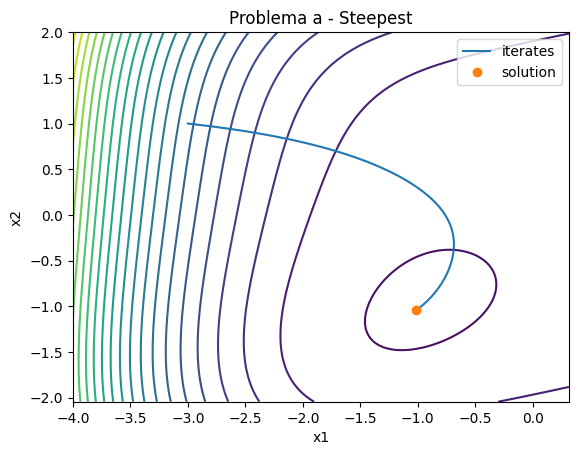

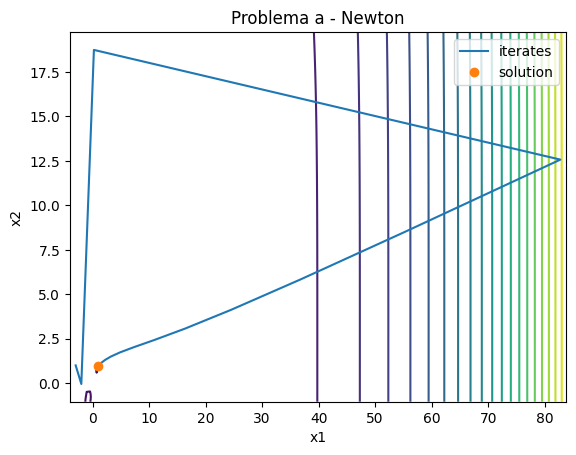

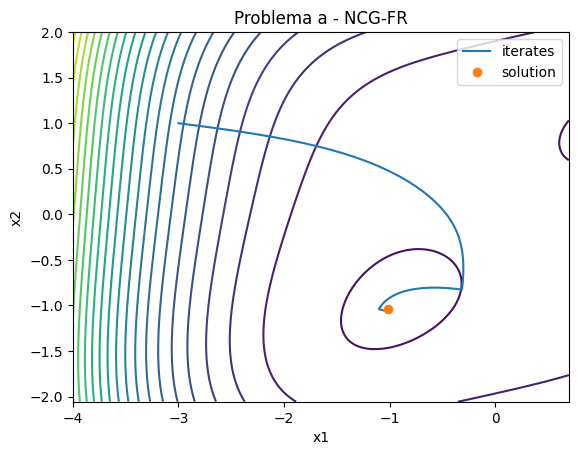

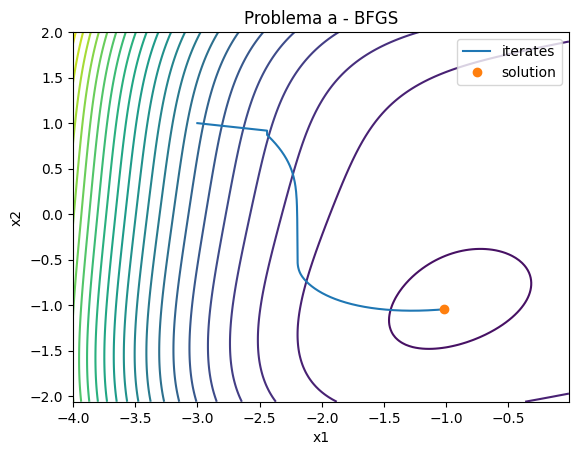

In [48]:
# Problema (a)
df_a_results = run_problem("a", (f_a, df_a, ddf_a), x0_a, xstar_a, fxstar_a, make_plots_2d=True)

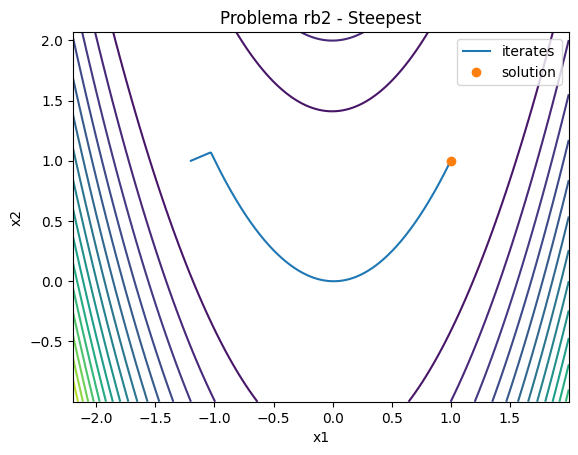

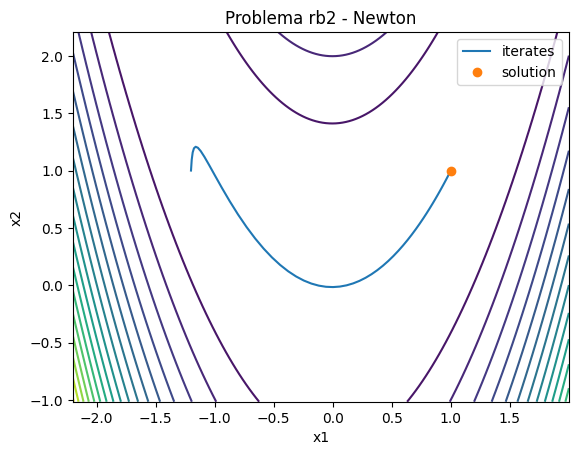

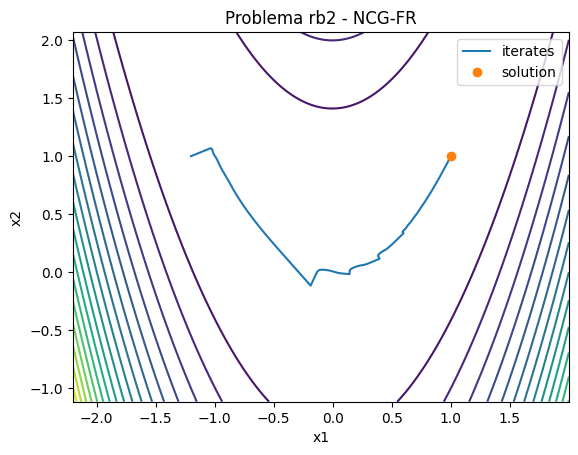

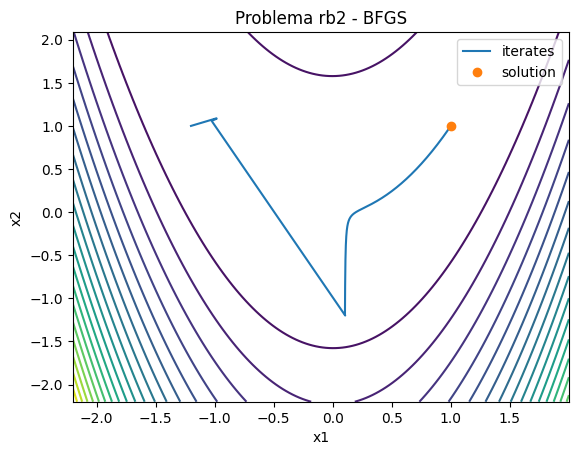

In [49]:
# Problema (b) Rosenbrock 2D
df_rb2_results = run_problem("rb2", (f_rb2, df_rb2, ddf_rb2), x0_rb2, xstar_rb2, fxstar_rb2, make_plots_2d=True)


In [50]:
# Problema (c) Rosenbrock 7D
df_rb7_results = run_problem("rb7", (f_rbn, df_rbn, ddf_rbn), x0_rbn7, xstar_rbn7, fxstar_rbn7, make_plots_2d=False)

#### Tabla de resultados

In [51]:
combined = pd.concat([df_a_results, df_rb2_results, df_rb7_results], ignore_index=True)
combined

,Problema,Método,α,Convergió,Iteraciones,f(x_final),||∇f|| final,Solución aprox
0,a,Steepest,0.00100,Sí,2187,-1.511319e+00,9.936911e-07,"[-1.0146283545213852, -1.0445303436969235]"
1,a,Newton,1.00000,Sí,18,-5.121797e-01,9.414203e-11,"[0.9831457213336828, 0.950284576367685]"
2,a,NCG-FR,0.00100,Sí,233,-1.511319e+00,9.850436e-07,"[-1.0146284740612475, -1.0445305062653714]"
3,a,BFGS,0.00500,Sí,2437,-1.511319e+00,9.960922e-07,"[-1.0146285244496378, -1.0445304964834299]"
4,rb2,Steepest,0.00030,Sí,106951,1.251738e-12,9.998960e-07,"[0.9999988820836795, 0.9999977596951538]"
5,rb2,Newton,0.25000,Sí,114,7.125680e-19,9.744769e-09,"[0.9999999991935952, 0.9999999983622345]"
6,rb2,NCG-FR,0.00010,Sí,2414,1.246598e-12,9.978680e-07,"[0.9999988843879174, 0.9999977642963989]"
7,rb2,BFGS,0.00100,Sí,28955,1.251678e-12,9.998721e-07,"[0.999998882110411, 0.9999977597487238]"
8,rb7,Steepest,0.00010,Sí,247608,3.983601e+00,9.999571e-07,"[-0.9917225439413245, 0.9935553369200285, 0.99..."
9,rb7,Newton,0.20000,Sí,126,3.983601e+00,8.060161e-09,"[-0.9917225725338246, 0.9935553934484145, 0.99..."


In [52]:
problems = {
    "a":   {"f": f_a,   "df": df_a,   "ddf": ddf_a,   "x0": x0_a,    "xstar": xstar_a},
    "rb2": {"f": f_rb2, "df": df_rb2, "ddf": ddf_rb2, "x0": x0_rb2,  "xstar": xstar_rb2},
    "rb7": {"f": f_rbn, "df": df_rbn, "ddf": ddf_rbn, "x0": x0_rbn7, "xstar": xstar_rbn7},
}

In [53]:
def run_with_alpha(mname, alpha, prob_key, target_iters):
    """Ejecuta un método con alpha fijo y retorna listas: xs, grad_norms."""
    P = problems[prob_key]
    f_fun, df_fun, ddf_fun = P["f"], P["df"], P["ddf"]
    x0 = P["x0"]

    # Forzar a ejecutar exactamente target_iters pasos: eps<0 evita el corte por tolerancia
    eps_force = -1.0
    kw_common = dict(maxIter=int(target_iters), eps=eps_force, criterion="grad_norm")

    if mname == "Random":
        best, xs, fs, errs, iters, conv = gd_random_direction_naive(
            f_fun, df_fun, ddf_fun, x0=x0, alpha=float(alpha), seed=0, **kw_common
        )
    elif mname == "Steepest":
        best, xs, fs, errs, iters, conv = steepest_descent_naive(
            f_fun, df_fun, ddf_fun, x0=x0, alpha=float(alpha), **kw_common
        )
    elif mname == "Newton":
        best, xs, fs, errs, iters, conv = newton_exact_hessian(
            f_fun, df_fun, ddf_fun, x0=x0, alpha=float(alpha), **kw_common
        )
    elif mname == "NCG-FR":
        best, xs, fs, errs, iters, conv = nonlinear_cg(
            f_fun, df_fun, x0=x0, alpha=float(alpha), beta_rule="FR", **kw_common
        )
    elif mname == "BFGS":
        best, xs, fs, errs, iters, conv = bfgs(
            f_fun, df_fun, x0=x0, alpha=float(alpha), **kw_common
        )
    else:
        raise ValueError(f"Método desconocido: {mname}")

    xs_arr = np.array(xs)
    grad_norms = [np.linalg.norm(df_fun(xk)) for xk in xs_arr]
    return xs_arr, grad_norms

In [54]:
def plot_problem(prob_key, df_combined):
    """Genera 2 figuras para un problema: (1) ||x_k - x*|| vs k (2) ||∇f(x_k)|| vs k."""
    P = problems[prob_key]
    xstar = P["xstar"]

    # Filtrar métodos convergentes con α válido
    dfp = df_combined[(df_combined["Problema"] == prob_key) &
                      (df_combined["Convergió"] == "Sí") &
                      df_combined["α"].notna()]

    # ---- Figura 1: error de aproximación ||x_k - x*|| ----
    plt.figure()
    for _, row in dfp.iterrows():
        mname = str(row["Método"])
        alpha = float(row["α"])
        iters = int(row["Iteraciones"])
        xs_arr, grad_norms = run_with_alpha(mname, alpha, prob_key, iters)
        err = [np.linalg.norm(xk - xstar) for xk in xs_arr]
        plt.semilogy(range(len(err)), err, label=f"{mname} (α={alpha:g})")
    plt.xlabel("Iteración k")
    plt.ylabel(r"$\|x_k - x^'*'\|_2$")
    plt.title(f"Evolución del error de aproximación — Problema {prob_key}")
    plt.legend()
    plt.show()

    # ---- Figura 2: norma del gradiente ||∇f(x_k)|| ----
    plt.figure()
    for _, row in dfp.iterrows():
        mname = str(row["Método"])
        alpha = float(row["α"])
        iters = int(row["Iteraciones"])
        xs_arr, grad_norms = run_with_alpha(mname, alpha, prob_key, iters)
        plt.semilogy(range(len(grad_norms)), grad_norms, label=f"{mname} (α={alpha:g})")
    plt.xlabel("Iteración k")
    plt.ylabel(r"$\|\nabla f(x_k)\|_2$")
    plt.title(f"Evolución de la norma del gradiente — Problema {prob_key}")
    plt.legend()
    plt.show()



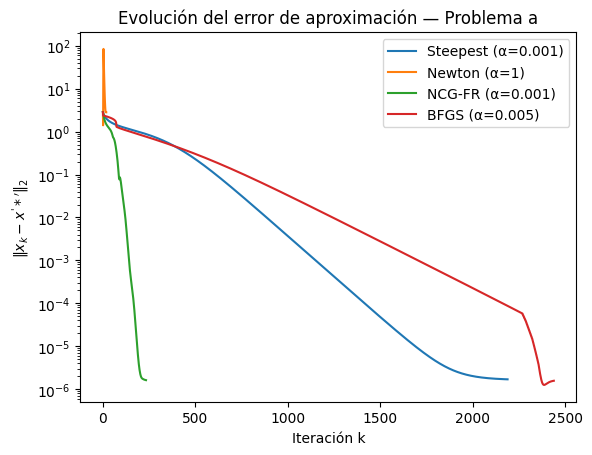

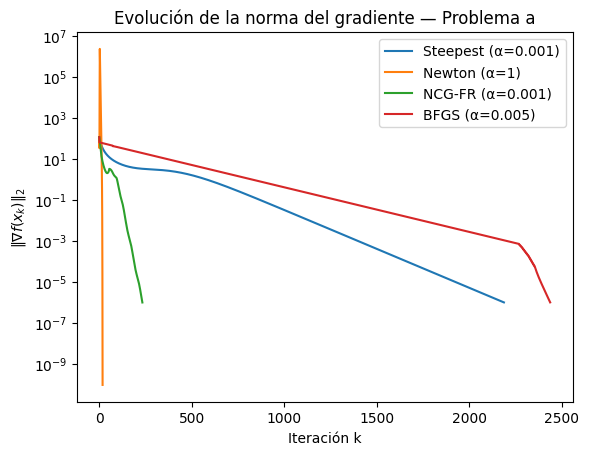

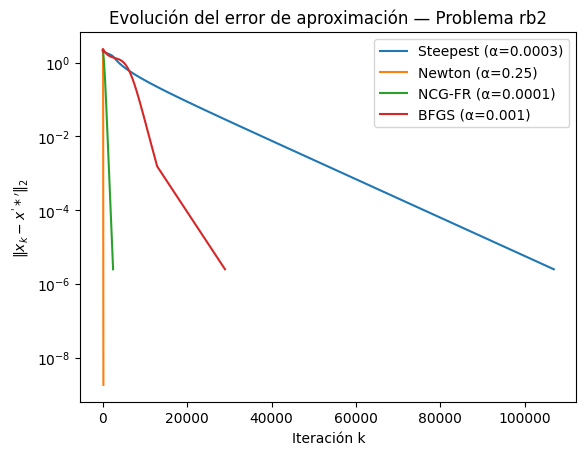

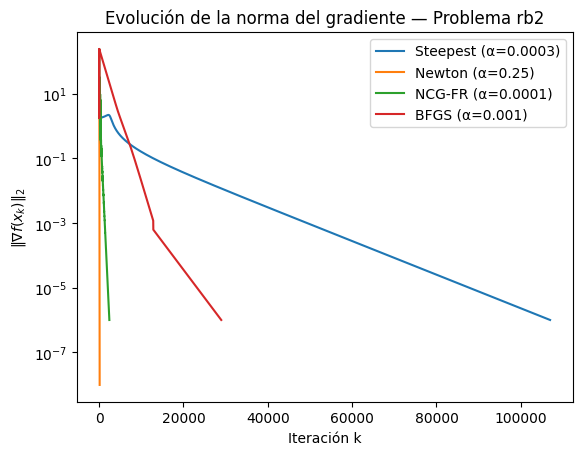

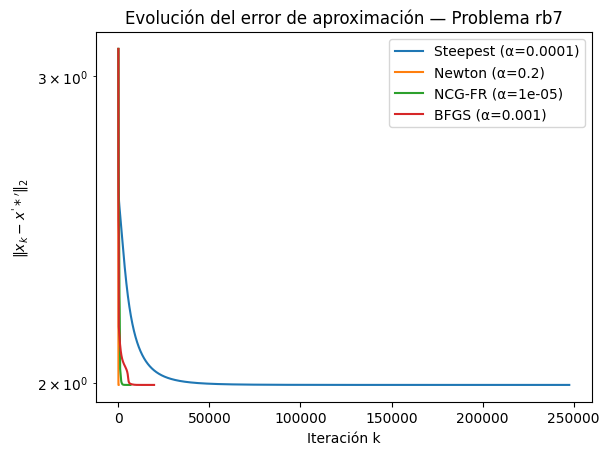

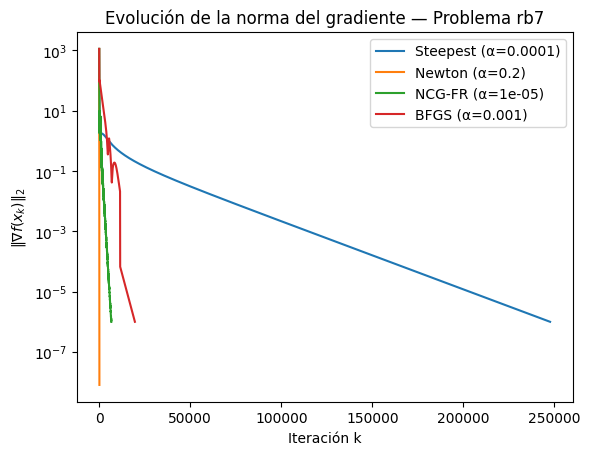

In [55]:
plot_problem("a",   combined)
plot_problem("rb2", combined)
plot_problem("rb7", combined)